# Notebook

## Setting up

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import warnings
import time

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from datasets import Dataset
from datasets import DatasetDict
from datasets import load_metric

from transformers import AutoTokenizer
from transformers import AutoModel
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
from transformers import TextClassificationPipeline
from transformers import pipeline

# suppress FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

C:\Users\sanct\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_pickle("data/data_original.pkl")

down_sample_percentage = 10

# down sample data
df = df.sample(frac=down_sample_percentage/100, random_state=1)

# rename emotions to label and map to integers
df.rename(columns={'emotions':'label'}, inplace = True)
label_map = {"sadness": 0, "joy": 1, "love": 2, "anger": 3, "fear": 4, "surprise": 5} 
df['label'] = df['label'].map(label_map)

print(df.shape)
df.head()

(41681, 2)


,text,label
98790,i wanted them to feel now i feel as though i a...,0
18398,i found myself feeling very sympathetic toward...,2
139349,ive been feeling pretty good today and tonight...,1
13416,i can use to cover my ass when i feel inadequate,0
22297,i feel like ive pissed myself again,3


In [3]:
dataset = Dataset.from_pandas(df)

# 80% train, 20% test+validation
train_test = dataset.train_test_split(test_size=0.2)

# Split the 10% test+validation set in half test, half validation
valid_test = train_test['test'].train_test_split(test_size=0.5)

# gather everyone if you want to have a single DatasetDict
train_valid_test_dataset = DatasetDict({
    'train': train_test['train'],
    'validation': valid_test['train'],
    'test': valid_test['test']
})

print(train_valid_test_dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 33344
    })
    validation: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 4168
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 4169
    })
})


## Fine-tuning a pre-trained Hugging Face model

We need to load:
- the pre-trained model itself
- the tokenizer associated with the model (used to preprocess the data)

In [4]:
model_name = "distilbert-base-uncased" # bert-base-uncased

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Pre-processing the data with the tokenizer

In [5]:
def preprocess_function(sample):
    return tokenizer(sample["text"], padding=True, truncation=True, return_tensors="pt")

tokenized_dataset = train_valid_test_dataset.map(preprocess_function, batched=True)

print(tokenized_dataset)

Map: 100%|██████████| 4169/4169 [00:00<00:00, 22700.52 examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 33344
    })
    validation: Dataset({
        features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 4168
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 4169
    })
})


The preprocessing transforms the data into a format that the model can understand. The model then processes the data to make predictions. This is known as **encoding**. Encoding is done in a two-step process: tokenization, followed by conversion to input IDs.

In [6]:
# print(tokenized_dataset['train'][321])
# tokens = tokenizer.tokenize(tokenized_dataset['train'][321]['text'])
# print(tokens)
# ids = tokenizer.convert_tokens_to_ids(tokens)
# print(ids)

### Model training (Fine-tuning)

In [7]:
def predict(text):
    global model, tokenizer
    inputs = tokenizer(text, return_tensors="pt")
    outputs = model(**inputs)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=1)
    print(predictions)
    predicted_class = torch.argmax(predictions)
    name = [i for i, j in label_map.items() if j == predicted_class.item()][0]
    print(f"Predicted class: {name}")
    
# predict("I'm so sad")

In [8]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

In [9]:
trainer.evaluate()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
100%|██████████| 261/261 [02:05<00:00,  2.08it/s]


{'eval_loss': 1.7781157493591309,
 'eval_accuracy': 0.27927063339731284,
 'eval_runtime': 126.0582,
 'eval_samples_per_second': 33.064,
 'eval_steps_per_second': 2.07}

In [10]:
start = time.time()
trainer.train()
end = time.time()
print(f"Training time: {(end - start)/60} minutes")

  8%|▊         | 500/6252 [21:26<1:15:31,  1.27it/s]

{'loss': 0.7125, 'learning_rate': 1.8400511836212414e-05, 'epoch': 0.24}


 16%|█▌        | 1000/6252 [28:36<1:15:24,  1.16it/s]

{'loss': 0.2604, 'learning_rate': 1.6801023672424827e-05, 'epoch': 0.48}


 24%|██▍       | 1500/6252 [35:46<1:07:58,  1.17it/s]

{'loss': 0.2077, 'learning_rate': 1.5201535508637238e-05, 'epoch': 0.72}


 32%|███▏      | 2000/6252 [42:59<1:03:28,  1.12it/s]

{'loss': 0.1819, 'learning_rate': 1.3602047344849649e-05, 'epoch': 0.96}


                                                     
 33%|███▎      | 2084/6252 [45:08<1:04:56,  1.07it/s]Checkpoint destination directory ./results\checkpoint-2084 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.14563977718353271, 'eval_accuracy': 0.9385796545105566, 'eval_runtime': 54.0128, 'eval_samples_per_second': 77.167, 'eval_steps_per_second': 4.832, 'epoch': 1.0}


 40%|███▉      | 2500/6252 [51:12<58:03,  1.08it/s]   

{'loss': 0.1431, 'learning_rate': 1.2002559181062061e-05, 'epoch': 1.2}


 48%|████▊     | 3000/6252 [58:33<45:00,  1.20it/s]

{'loss': 0.1294, 'learning_rate': 1.0403071017274472e-05, 'epoch': 1.44}


 56%|█████▌    | 3500/6252 [1:05:46<37:20,  1.23it/s]

{'loss': 0.134, 'learning_rate': 8.803582853486885e-06, 'epoch': 1.68}


 64%|██████▍   | 4000/6252 [1:12:57<31:21,  1.20it/s]

{'loss': 0.1173, 'learning_rate': 7.204094689699297e-06, 'epoch': 1.92}


                                                     
 67%|██████▋   | 4168/6252 [1:16:17<31:06,  1.12it/s]

{'eval_loss': 0.1369013637304306, 'eval_accuracy': 0.9364203454894434, 'eval_runtime': 53.0774, 'eval_samples_per_second': 78.527, 'eval_steps_per_second': 4.917, 'epoch': 2.0}


 72%|███████▏  | 4500/6252 [1:21:07<26:19,  1.11it/s]  

{'loss': 0.0991, 'learning_rate': 5.6046065259117085e-06, 'epoch': 2.16}


 80%|███████▉  | 5000/6252 [1:28:37<19:43,  1.06it/s]

{'loss': 0.1018, 'learning_rate': 4.005118362124121e-06, 'epoch': 2.4}


 88%|████████▊ | 5500/6252 [1:36:20<12:34,  1.00s/it]

{'loss': 0.0979, 'learning_rate': 2.4056301983365325e-06, 'epoch': 2.64}


 96%|█████████▌| 6000/6252 [1:44:33<03:42,  1.13it/s]

{'loss': 0.0858, 'learning_rate': 8.061420345489445e-07, 'epoch': 2.88}


                                                     
100%|██████████| 6252/6252 [1:49:42<00:00,  1.05it/s]

{'eval_loss': 0.14082451164722443, 'eval_accuracy': 0.9337811900191939, 'eval_runtime': 63.2632, 'eval_samples_per_second': 65.884, 'eval_steps_per_second': 4.126, 'epoch': 3.0}


100%|██████████| 6252/6252 [1:49:42<00:00,  1.05s/it]

{'train_runtime': 6582.9052, 'train_samples_per_second': 15.196, 'train_steps_per_second': 0.95, 'train_loss': 0.18534225663998458, 'epoch': 3.0}
Training time: 109.71698013146718 minutes


In [11]:
trainer.evaluate()

100%|██████████| 261/261 [00:58<00:00,  4.46it/s]


{'eval_loss': 0.1369013637304306,
 'eval_accuracy': 0.9364203454894434,
 'eval_runtime': 58.6906,
 'eval_samples_per_second': 71.016,
 'eval_steps_per_second': 4.447,
 'epoch': 3.0}

In [12]:
trainer.predict(test_dataset=tokenized_dataset["test"])

100%|██████████| 261/261 [00:48<00:00,  5.34it/s]


PredictionOutput(predictions=array([[-1.1589271 , -1.7797425 , -3.3505602 , -0.83839375,  6.5645027 ,
        -2.001337  ],
       [ 7.2704763 , -2.0339503 , -2.744355  , -2.0665889 , -1.2297791 ,
        -2.5538201 ],
       [-1.2017508 , -2.0048738 , -2.8264852 ,  6.9614906 , -0.8082159 ,
        -2.4410818 ],
       ...,
       [ 7.4346123 , -1.7028426 , -2.5844927 , -1.833561  , -1.9962671 ,
        -2.6132402 ],
       [ 7.345807  , -2.014604  , -2.8145783 , -1.561603  , -1.3454788 ,
        -2.7238307 ],
       [-1.4852011 , -2.0718799 , -3.6946545 , -0.6286919 ,  6.4481955 ,
        -1.2961009 ]], dtype=float32), label_ids=array([4, 0, 3, ..., 0, 0, 4], dtype=int64), metrics={'test_loss': 0.13709861040115356, 'test_accuracy': 0.936195730390981, 'test_runtime': 49.1011, 'test_samples_per_second': 84.906, 'test_steps_per_second': 5.316})

### Save & Load Model

In [13]:
trainer.save_model()

tokenizer2 = AutoTokenizer.from_pretrained("./results")
model2 = AutoModelForSequenceClassification.from_pretrained("./results", num_labels=6)

pipe = TextClassificationPipeline(model=model2, tokenizer=tokenizer2) #, return_all_scores=True)

# pipe("I love this place!")
# pipe("Paris was very disappointing")

### Evaluate Model Results

In [14]:
def show_cm(cm, classes, figsize=(10, 10)):
    # cm = np.array([[TP, FP], [FN, TN]])
    plt.figure(figsize=figsize)
    plt.imshow(cm)
    plt.suptitle('Confusion matrix')
    total = sum(sum(cm))
    plt.title('Total cases: {}'.format(total))
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    for i in range(len(classes)):
        for j in range(len(classes)):
            perc = round(cm[i, j] / total * 100, 1)
            plt.text(j, i, f"{format(cm[i, j], '.0f')} : {perc}%", horizontalalignment="center",
                     color="black" if cm[i, j] > cm.max() / 2 else "white")

    plt.show()

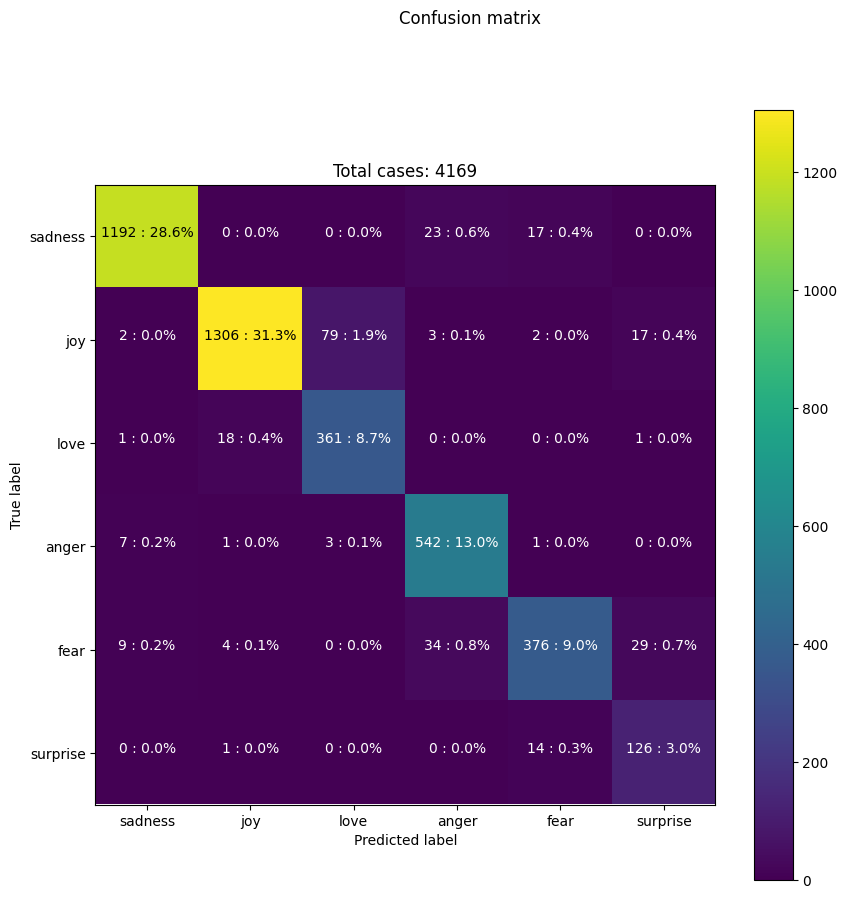

Accuracy:  0.936195730390981
Precision:  0.8878154817250933
Recall:  0.9242920528883779
F1:  0.9030582492159595


In [15]:
y_pred= []
for p in tokenized_dataset['test']['text']:
    ti = tokenizer2(p, return_tensors="pt")
    out = model2(**ti)
    pred = torch.argmax(out.logits)
    y_pred.append(pred)
    
y_test = tokenized_dataset['test']['label']

show_cm(confusion_matrix(y_test, y_pred), label_map.keys())
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred, average='macro'))
print('Recall: ', recall_score(y_test, y_pred, average='macro'))
print('F1: ', f1_score(y_test, y_pred, average='macro'))